In [ ]:
# Code adapted from https://towardsdatascience.com/web-scraping-using-python-and-beautifulsoap-a-step-by-step-tutorial-8389ee7da6a0

In [ ]:
# Install & Import Libraries
!pip install seaborn
!pip install bs4

import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scraping Data


In [ ]:
searchTerm="data+science"

#get columns

book_title = []
author = []
published = []
n_ratings = []
avg_rating = []
editions = []

for page in range(1, 101):

    url = 'https://www.goodreads.com/search?page=' + str(page) + '&q='+ searchTerm + '&qid=1CdWeOJnHr&tab=books'
    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'html.parser')
    
    #selecting table containing list of books
    table = soup.table
    
    #selecting rows with each book
    book_list = table.find_all('tr')

    #scrap from book_list
    for book in book_list:

        #title list
        title = book.find_all('a', class_ = 'bookTitle')
        book_title.append(title[0].text.strip())

        #author list
        authors_for_book = []
        authors_names = book.find_all('a', class_ = 'authorName')
        for authors in authors_names:   
            authors_for_book.append(authors.text.strip())
        author.append(authors_for_book)

        #published year
        pattern = re.compile(r"published\s*(\d{4})")
        year_pub = pattern.search(book.text)
        published.append(year_pub.group(1) if year_pub else 0)

        #rating
        all_ratings = book.find_all('span', class_ = 'minirating')
        all_ratings_text = all_ratings[0].text.strip()
        pattern_2 = re.compile(r"(\d\.?\d*)\savg")
        avg_rating.append(pattern_2.search(all_ratings_text).group(1))

        #n_ratings
        pattern_4 = re.compile(r"(\d\,?\d*) rating")
        ratings_matches = pattern_4.search(all_ratings_text)
        n_ratings.append(ratings_matches.group(1) if ratings_matches else 0)  

        #editions
        pattern_3 = re.compile(r"(\d+) edition")
        eds = book.find(href=re.compile("editions"))
        editions.append(pattern_3.search(eds.text).group(1))

df = pd.DataFrame({
    'Title': book_title, 
    'Author(s)': author,
    'Published Year': published,
    'Editions': editions,
    'Avg. Rating': avg_rating,
    'Num. of Ratings': n_ratings})

print(df.info())
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965 entries, 0 to 1964
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            1965 non-null   object
 1   Author(s)        1965 non-null   object
 2   Published Year   1965 non-null   object
 3   Editions         1965 non-null   object
 4   Avg. Rating      1965 non-null   object
 5   Num. of Ratings  1965 non-null   object
dtypes: object(6)
memory usage: 92.2+ KB
None


(1965, 6)

# Exploratory Analysis

## Pre-Processing


In [ ]:
df.head()

,Title,Author(s),Published Year,Editions,Avg. Rating,Num. of Ratings
0,Data Science for Business: What you need to kn...,"[Foster Provost, Tom Fawcett]",2013,14,4.16,"1,751"
1,Data Smart: Using Data Science to Transform In...,[John W. Foreman],2013,15,4.14,894
2,Data Science from Scratch: First Principles wi...,[Joel Grus],2015,20,3.94,752
3,Doing Data Science,"[Rachel Schutt, Cathy O'Neil]",2013,10,3.70,512
4,"R for Data Science: Import, Tidy, Transform, V...","[Hadley Wickham, Garrett Grolemund]",2016,14,4.60,638


In [ ]:
# changing datatypes
df['Published Year'] = pd.to_numeric(df['Published Year'])
df['Editions'] = pd.to_numeric(df['Editions'], downcast='float')
df['Avg. Rating'] = pd.to_numeric(df['Avg. Rating'])

# removing commas and changing datatype for Num. of Ratings
df['Num. of Ratings'] = df['Num. of Ratings'].replace(',','', regex=True)
df['Num. of Ratings'] = pd.to_numeric(df['Num. of Ratings'])

# getting first author
df['Author(s)'] = df['Author(s)'].apply(lambda x: x[0])

# stardardizing all titles
df['Title'] = df['Title'].apply(lambda x: x.capitalize())

# selecting only rows with at least 1 Rating
df = df[df['Num. of Ratings'] != 0]

# creating a new column for Weighted Avg to be used later
df['Weighted Rating'] = df['Avg. Rating'] * df['Num. of Ratings']

# creating BookID column
r1, r2 = 1, len(df)
df['BookID'] = np.arange(r1, r2+1, 1)

In [ ]:
print(df.shape)
df.head()

(837, 8)


,Title,Author(s),Published Year,Editions,Avg. Rating,Num. of Ratings,Weighted Rating,BookID
0,Data science for business: what you need to kn...,Foster Provost,2013,14.0,4.16,1751,7284.16,1
1,Data smart: using data science to transform in...,John W. Foreman,2013,15.0,4.14,894,3701.16,2
2,Data science from scratch: first principles wi...,Joel Grus,2015,20.0,3.94,752,2962.88,3
3,Doing data science,Rachel Schutt,2013,10.0,3.70,512,1894.40,4
4,"R for data science: import, tidy, transform, v...",Hadley Wickham,2016,14.0,4.60,638,2934.80,5


## Inspecting Features

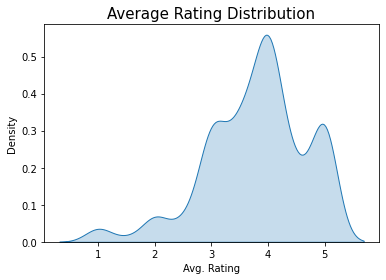

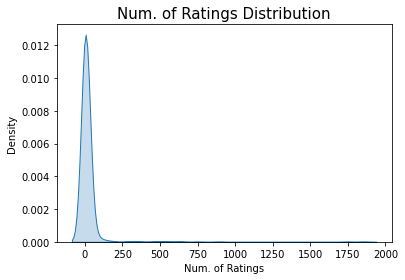

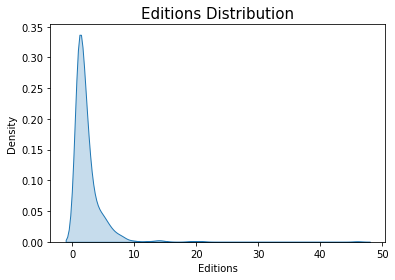

In [ ]:
plt.figure()
sns.kdeplot(df['Avg. Rating'], shade = True)
plt.title('Average Rating Distribution',fontsize=15)

plt.figure()
sns.kdeplot(df['Num. of Ratings'], shade = True)
plt.title('Num. of Ratings Distribution',fontsize=15)

plt.figure()
sns.kdeplot(df['Editions'], shade = True)
plt.title('Editions Distribution',fontsize=15);

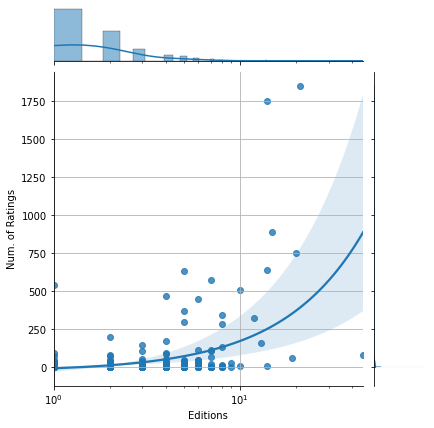

In [ ]:
from scipy.stats import pearsonr

sns.jointplot(x='Editions', y='Num. of Ratings', data=df,  kind='reg')
plt.grid()

# log transformation to editions
plt.xscale('log')

## Exploring best rated authors


In [ ]:
def authors_df(author, feature):
    authors = author.map(lambda x: x.split(','))
    features = feature
    
    auth_feature = list(map(lambda tuple_auth_feature: 
                     list(map(lambda i: (i, tuple_auth_feature[1]), tuple_auth_feature[0])),
                     zip(authors, features)))
    
    flat_list = []
    for sublist in auth_feature:
        for item in sublist:
            flat_list.append(item)
    
    flat_list = set(flat_list)
    
    authors = list(map(lambda i: i[0], flat_list))
    features = list(map(lambda i: i[1], flat_list))
    df_auth_feature = pd.DataFrame({'Authors': authors, 'Feature': features})
    
    return df_auth_feature

In [ ]:
# calling the function to create a new dataframe with the individual authors
most_books = authors_df(df['Author(s)'], df['Title'])

# selecting the top 10 by counting the books
top_20_most_books = pd.crosstab(index=most_books['Authors'],columns='count').sort_values(['count'], 
                                                            ascending=False).reset_index().head(20)

In [ ]:
most_popular = authors_df(df['Author(s)'], df['Num. of Ratings'])
top_20_most_popular = most_popular.groupby(['Authors'])['Feature'].sum().sort_values(
                            ascending=False).reset_index('Authors').head(20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '\nMost Popular Authors\n')

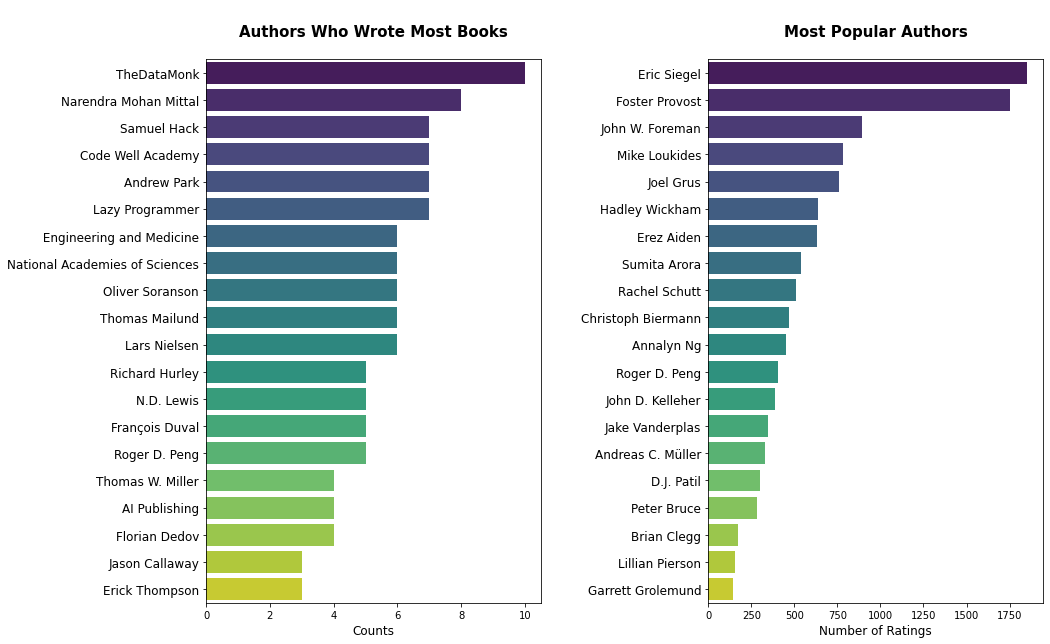

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
ax = sns.barplot(top_20_most_books['count'], top_20_most_books['Authors'], palette = 'viridis')
plt.ylabel('')
plt.xlabel('Counts', fontsize=12)
plt.yticks(fontsize=12)
plt.title('\nAuthors Who Wrote Most Books\n', fontsize=15, fontweight='bold')


plt.subplot(1, 2, 2)
plt.subplots_adjust(wspace = 0.5)
ax2 = sns.barplot(top_20_most_popular['Feature'], top_20_most_popular['Authors'], palette = 'viridis')
plt.ylabel('')
plt.xlabel('Number of Ratings', fontsize=12)
plt.yticks(fontsize=12)
plt.title('\nMost Popular Authors\n', fontsize=15, fontweight='bold')

## Exploring most rated and popular books

In [ ]:
most_rated_books = df[['BookID', 'Avg. Rating']].sort_values(by='Avg. Rating', 
                                                        ascending=False).set_index('BookID').head(10)
most_popular_books = df[['BookID', 'Num. of Ratings']].sort_values(by='Num. of Ratings', 
                                                            ascending=False).set_index('BookID').head(10)

# using set_table_attributes to display two dataframes side by side

from IPython.display import display_html 

# creating a function to highlight Books ID in table

def highlight_cols(s):
    color = 'red'
    return 'background-color: %s' % color

# applying styles and displaying

df1_styler = most_rated_books.reset_index().style.set_table_attributes(
                    "style='display:inline'").set_caption('Most Rated Books').applymap(highlight_cols, 
                    subset=pd.IndexSlice[:, ['BookID']]).format({'Avg. Rating': '{:,.1f}'})

df2_styler = most_popular_books.reset_index().style.set_table_attributes(
                        "style='display:inline'").set_caption('Most Popular Books').applymap(highlight_cols, 
                        subset=pd.IndexSlice[:, ['BookID']]).format({'Num. of Ratings': '{:,.1f}'})

display_html(df1_styler._repr_html_() + ' ' + df2_styler._repr_html_(), raw=True)

,BookID,Avg. Rating
0,419,5.0
1,610,5.0
2,534,5.0
3,531,5.0
4,529,5.0
5,527,5.0
6,526,5.0
7,122,5.0
8,525,5.0
9,522,5.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


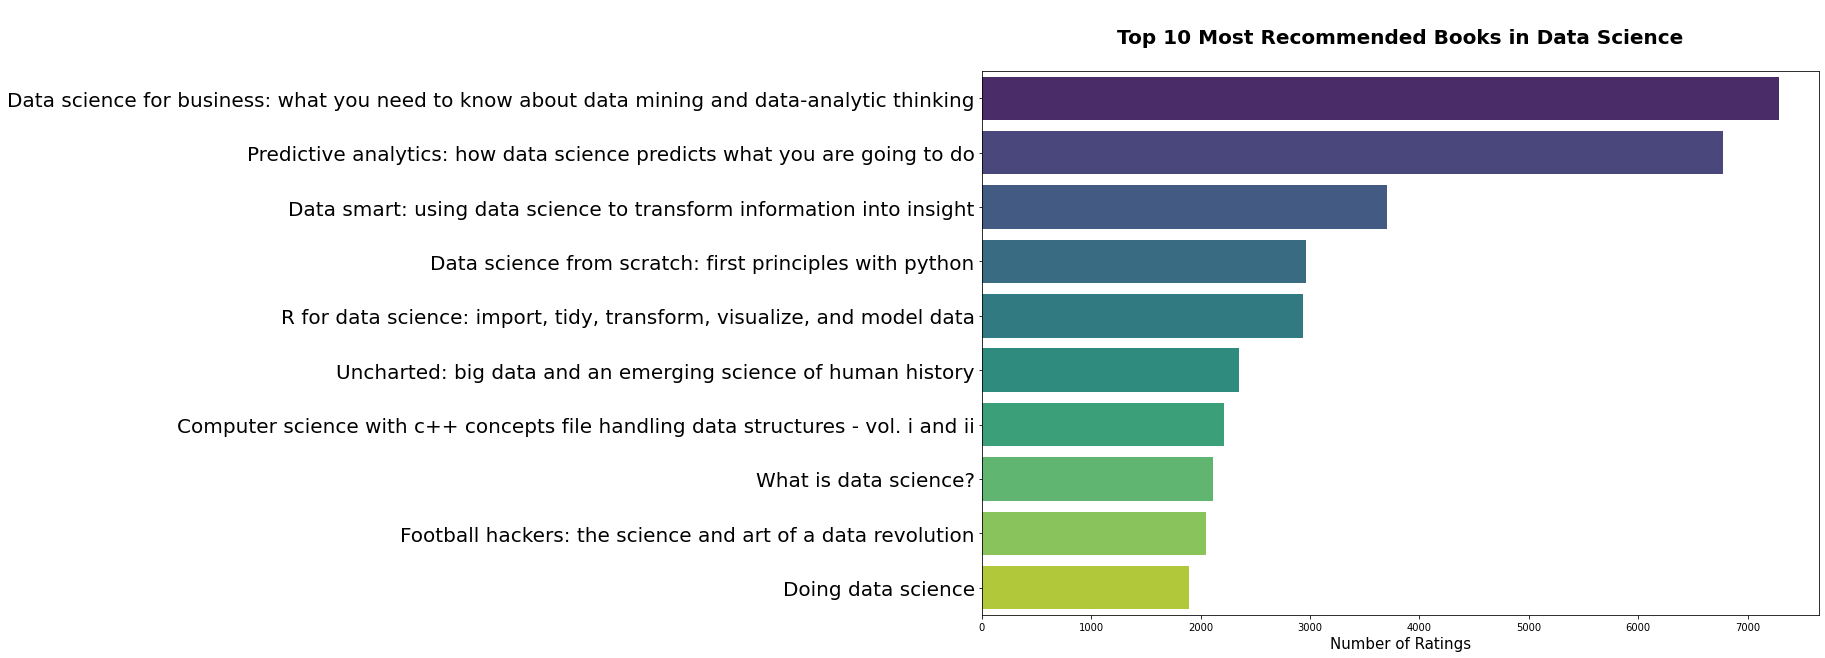

In [ ]:
most_recommended = df.sort_values(by='Weighted Rating', ascending=False).set_index('Title').head(10)

plt.figure(figsize=(15,10))
sns.barplot(most_recommended['Weighted Rating'], most_recommended.index, palette = 'viridis')
plt.ylabel('')
plt.xlabel('Number of Ratings', fontsize=15)
plt.yticks(fontsize=20)
plt.title('\nTop 10 Most Recommended Books in Data Science\n', fontsize=20, fontweight='bold');

In [ ]:
# making a table with all information about the top 10 books

print("\n\nMost Recommended Books in Data Science Based on Goodreads Reviews")
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '12px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7ffff')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '12px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

most_recommended.drop(most_recommended[['Weighted Rating', 'BookID']],axis=1).reset_index().style.set_table_styles(
                                        styles).format({'Avg. Rating': '{:.1f}',
                                                        'Num. of Ratings': '{:,.0f}', 
                                                        'Editions': '{:.0f}', 
                                                        'Published Year': '{:.0f}'})



Most Recommended Books in Data Science Based on Goodreads Reviews


,Title,Author(s),Published Year,Editions,Avg. Rating,Num. of Ratings
0,Data science for business: what you need to know about data mining and data-analytic thinking,Foster Provost,2013,14,4.2,"1,751"
1,Predictive analytics: how data science predicts what you are going to do,Eric Siegel,2013,21,3.7,"1,852"
2,Data smart: using data science to transform information into insight,John W. Foreman,2013,15,4.1,894
3,Data science from scratch: first principles with python,Joel Grus,2015,20,3.9,752
4,"R for data science: import, tidy, transform, visualize, and model data",Hadley Wickham,2016,14,4.6,638
5,Uncharted: big data and an emerging science of human history,Erez Aiden,2013,5,3.7,631
6,Computer science with c++ concepts file handling data structures - vol. i and ii,Sumita Arora,0,1,4.1,540
7,What is data science?,Mike Loukides,2011,7,3.7,573
8,Football hackers: the science and art of a data revolution,Christoph Biermann,0,4,4.3,471
9,Doing data science,Rachel Schutt,2013,10,3.7,512
